In [1]:
import os
import pandas as pd
import numpy as np
import xarray as xr

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

from mpas_tools.mesh.interpolation import interp_bilin

from scripts import isinside

import matplotlib.pyplot as plt
%matplotlib inline

# Create the mesh

In [2]:
length = 200e3  # in meter
width = 100e3  # in meter
grid_resolution = 1000.  # in meter
node_x = int(length/grid_resolution+1)
node_y = int(width/grid_resolution+1)
node_x, node_y

(201, 101)

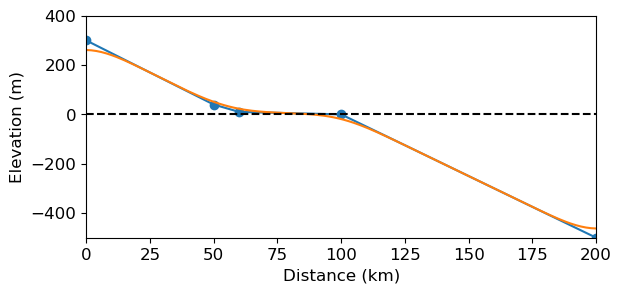

In [3]:
# Build initial surface profile based on given points
xdata = np.array([0,50,60,100,200])*1000
elev = np.array([300,40,10,0,-500])

f = interp1d(xdata, elev)
xnew = np.linspace(0, length, node_x)
ynew = np.linspace(0, width, node_y)
elev_new = f(xnew)
elev_new_gs = gaussian_filter1d(elev_new,sigma=10) 

# Visualize the profile
fig = plt.figure(figsize = (6,3))
plt.rc("font", size=12)
ax = fig.add_axes([0.11, 0.18, 0.85, 0.74])
ax.scatter(xdata/1e3, elev) 
ax.plot(xnew/1e3,elev_new)
ax.plot(xnew/1e3, elev_new_gs)
ax.axhline(y=0., color='k', linestyle='--')
ax.set_xlim([0,200])
ax.set_ylim([-500,400]) 
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Elevation (m)')
plt.show()

In [4]:
elev = np.broadcast_to(elev_new_gs, (node_x, node_x))[:node_y,:]
elev.shape

(101, 201)

In [5]:
from perlin_noise import PerlinNoise

noise1 = PerlinNoise(octaves=3)
noise2 = PerlinNoise(octaves=6)
noise3 = PerlinNoise(octaves=12)
noise4 = PerlinNoise(octaves=24)

xpix = 101
ypix = 201
perlin = np.zeros((xpix,ypix))
for i in range(xpix):
    row = []
    for j in range(ypix):
        noise_val = noise1([i/xpix, j/ypix])
        noise_val += 0.5 * noise2([i/xpix, j/ypix])
        noise_val += 0.25 * noise3([i/xpix, j/ypix])
        noise_val += 0.125 * noise4([i/xpix, j/ypix])

        row.append(noise_val)
    # pic.append(row)
    perlin[i,:] = np.asarray(row)

In [6]:
perlin.min(), perlin.max()

(-0.6735399498502528, 0.8604472446154698)

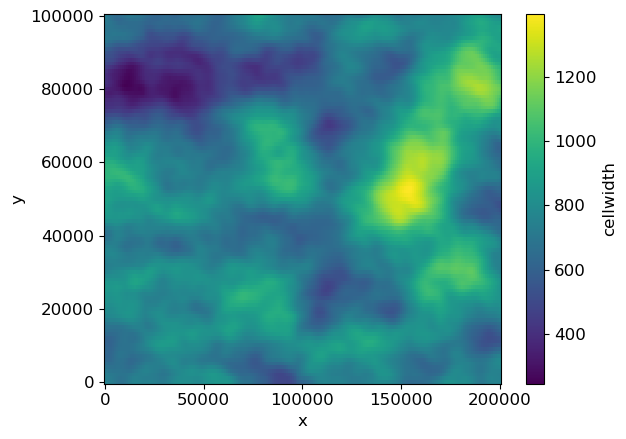

In [29]:
noise = np.random.normal(0, 0.1, elev.shape)
ds = xr.Dataset({
    'elev': xr.DataArray(
                data   = elev+perlin*1.5,
                dims   = ['y','x'],
                coords = {'x': xnew,'y': ynew},
                ),
        }
    )

anoise = (np.random.random_sample(elev.shape)+0.5)
wdth = (['y','x'],500.*anoise)
ds['cellwidth'] = (['y','x'],750.*(1+(perlin)))
ds['u'] = (['y','x'],-0.05*np.ones(elev.shape))
ds['v'] = (['y','x'],-0.05*np.ones(elev.shape))
# ds.elev.plot()
ds['cellwidth'].plot()

In [30]:
from scripts import umeshFcts as ufcts

output_path = "test_mesh7" 
if not os.path.exists(output_path):
    os.makedirs(output_path)
    
# Build your planar mesh
ufcts.planarMesh(ds,output_path,fvtk='planar.vtk',fumpas=True,voro=True)

Running: jigsaw test_mesh7/mesh2D.jig


 
#------------------------------------------------------------
#
#   ,o, ,o,       /                                 
#    `   `  e88~88e  d88~\   /~~~8e Y88b    e    / 
#   888 888 88   88 C888         88b Y88b  d8b  /   
#   888 888 "8b_d8"  Y88b   e88~-888  Y888/Y88b/  
#   888 888  /        888D C88   888   Y8/  Y8/     
#   88P 888 Cb      \_88P   "8b_-888    Y    Y    
# \_8"       Y8""8D                             
#
#------------------------------------------------------------
# JIGSAW: an unstructured mesh generation library.  
#------------------------------------------------------------
 
  JIGSAW VERSION 0.9.14

  Reading CFG. file...

  CFG. data summary...

  GEOM-FILE = test_mesh7/mesh2D.msh 
  MESH-FILE = test_mesh7/mesh2D-MESH.msh 
  HFUN-FILE = test_mesh7/mesh2D-HFUN.msh 
  INIT-FILE =  
  TRIA-FILE =  
  BNDS-FILE =  

  GEOM-SEED = 8 
  GEOM-PHI1 = 6.00e+01 
  GEOM-PHI2 = 6.00e+01 
  GEOM-ETA1 = 4.50e+01 
  GEOM-ETA2 = 4.50e+01 
  GEOM-FEAT = FALSE 

  INIT-NEAR =

Build time indices:   0% |                                     | ETA:  --:--:--
Build time indices: 100% |#####################################| Time:  0:00:00


maxEdges=
nVertLevels=
nParticles=

Extracting a total of 1 time levels.
Using file 'test_mesh7/base2D.nc' as the mesh file for this extraction.


The following variables will be extracted from the input file(s).

   Variables with 'nCells' as a dimension:
      name: areaCell

 -- Extracting cell fields --
Build geometry for fields on cells...


Writing time series:   0% |                                    | ETA:  --:--:--
Writing time series:   0% |                                    | ETA:  --:--:--
Writing time series: 100% |####################################| Time:  0:00:00


In [32]:
import uxarray as uxr
import meshio
import meshplex
import numpy as np

# Loading the UGRID file
ufile = output_path+'/base2D.nc'
var_name = 'data'
ugrid = uxr.open_grid(ufile) 

# Perform the interpolation (bilinear) 
ufcts.inter2UGRID(ds[['elev','u','v']],ugrid,output_path,var_name,type='face',latlon=False)

data_file = [output_path+'/'+var_name+'.nc']
# Get the information related to the mesh: primal and dual mesh
primal_mesh = uxr.open_dataset(ufile, *data_file, use_dual=False)
dual_mesh = uxr.open_dataset(ufile, *data_file, use_dual=True)

# Extract nodes and faces information
ucoords = np.empty((dual_mesh.uxgrid.n_node,3))
ucoords[:,0] = dual_mesh.uxgrid.node_x.values
ucoords[:,1] = dual_mesh.uxgrid.node_y.values
ucoords[:,2] = dual_mesh.uxgrid.node_z.values
ufaces = primal_mesh.uxgrid.node_face_connectivity.values

# Get information about your mesh:
print("Number of nodes: ",len(ucoords)," | number of faces ",len(ufaces))
edge_min = np.round(dual_mesh.uxgrid.edge_node_distances.min().values/1000.+0.,2)
edge_max = np.round(dual_mesh.uxgrid.edge_node_distances.max().values/1000.+0.,2)
edge_mean = np.round(dual_mesh.uxgrid.edge_node_distances.mean().values/1000.+0.,2)
print("edge range (km): min ",edge_min," | max ",edge_max," | mean ",edge_mean)

mesh = meshio.read(output_path+'/planar.vtk')
vertex = mesh.points
cells = mesh.cells_dict['triangle']
Umesh = meshplex.MeshTri(vertex, cells)
Uarea = Umesh.control_volumes
print('Cell area (km2): ',Uarea.min()*1.e-6,Uarea.max()*1.e-6)

meshname = output_path+"/gospl_mesh"
np.savez_compressed(meshname, v=vertex, c=cells, 
                    z=primal_mesh.elev.data,
                   )

meshname = output_path+"/vel"
uv = np.concatenate([primal_mesh.u.data, primal_mesh.v.data]).reshape((len(vertex),2))
np.savez_compressed(meshname, uv=uv
                   )

Number of nodes:  49459  | number of faces  98075
edge range (km): min  0.06  | max  1.03  | mean  0.38
Cell area (km2):  0.04316778360127991 1.7835942275049852


In [28]:
uv.shape

(49459, 2)

Build the triangular grid and interpolate the variables on the unstructured mesh:

In [48]:
# pts2D, cells = isinside.delaunayMesh([xnew[0],ynew[0],xnew[-1],ynew[-1]], 500)
# hData = interp_bilin(xnew, ynew, ds.elev.values, pts2D[:,0], pts2D[:,1])

Save the goSPL mesh:

In [74]:
# name of the folder where the inputs would be stored
mesh_path = 'inputs'
if not os.path.exists(mesh_path):
    os.makedirs(mesh_path)

coords = np.zeros((len(pts2D),3))
coords[:,:2] = pts2D

# Elevation mesh
elevfname = mesh_path+"/mesh2"
np.savez_compressed(elevfname, v=coords, c=cells, z=hData)

Make a sea-level curve

In [34]:
def buildCurve(timeExt = None, timeStep = None, seaExt = None,
                   ampExt = None, periodExt = None):
        """
        Curve created which interpolate linearly the averaged values of sea-level
        trends over the specified time period.

        Parameters
        ----------
        variable: timeExt
            Extent of the simulation time: start/end time (in years)

        variable: timeStep
            Discretisation step for time range (in years).

        variable: seaExt
            Sea level value for starting and ending times (in metres)

        variable: ampExt
            Amplitude of the sea level wave for starting and ending times (in metres)

        variable: periodExt
            Period of the sea level wave for starting and ending times (in years)
        """

        dt = float(timeStep)
        so = float(seaExt[0])
        sm = float(seaExt[1])
        to = float(timeExt[0])
        tm = float(timeExt[1])+dt
        Ao = float(ampExt[0])
        Am = float(ampExt[1])
        Po = float(periodExt[0])
        Pm = float(periodExt[1])

        time = np.arange(to,tm,dt,dtype=float)

        # Sea-level
        a0 = (sm - so)/(tm - to)
        b0 = so - a0 * to
        sl = a0 * time + b0
        # Amplitude
        a1 = (Am - Ao)/(tm - to)
        b1 = Ao - a1 * to
        A = a1 * time + b1
        # Period
        a2 = (Pm - Po)/(tm - to)
        b2 = Po - a2 * to
        P = a2 * time + b2

        for t in range(len(time)):
            sl[t] += A[t] * np.cos(2.* np.pi * (time[t] - to) / P[t])

        return time, sl

timeExt = [0.,5.e5]
timeStep = 5.e3
seaExt = [0.,-40]
ampExt = [1,20]
periodExt = [2.e4,1.e5]
time, sl = buildCurve(timeExt,timeStep,seaExt,ampExt,periodExt)

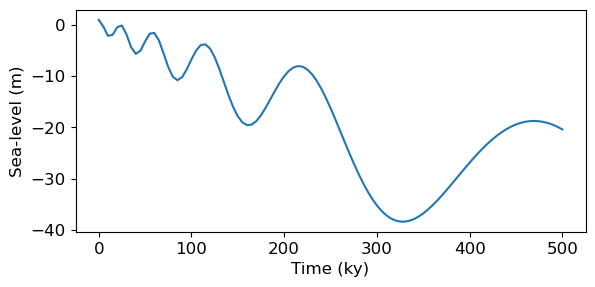

In [35]:
# Visualize the profile
fig = plt.figure(figsize = (6,3))
plt.rc("font", size=12)
ax = fig.add_axes([0.11, 0.18, 0.85, 0.74])
ax.plot(time/1000,sl)
ax.set_xlabel('Time (ky)')
ax.set_ylabel('Sea-level (m)')
plt.show()

Save it as file for goSPL simulation:

In [36]:
df = pd.DataFrame({'X':np.around(time, decimals=0),'Y':np.around(sl, decimals=3)})
df.to_csv('inputs/sealevel.csv',columns=['X', 'Y'], sep=' ', index=False ,header=0)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('test.csv', header=None)
tx,ty = np.asarray(df[1]), np.asarray(df[2])

cc = np.zeros((int(len(tx)/2),2))
mpt = np.zeros((int(len(tx)/2),2))

cc[:,0] = tx[::2]
cc[:,1] = ty[::2]

mpt[:,0] = tx[1::2]
mpt[:,1] = ty[1::2]

pt = np.asarray([7832.7635745580283, 61694.526657768729])

ngb = np.asarray([
   [7608.6587571548353,60951.811927963041],     
   [7140.1460822069903,61272.251499304941],   
   [8237.6213994186819,62374.138736087771],     
   [7275.8303138743813,62234.594692555031],     
   [7061.0704722902929,61774.137555050787],     
   [8124.0253422521819,61201.474318698703],     
   [8588.1169291337337,61748.351981279338],     
   [7773.2657490401252,62190.367430243845],    
]
)

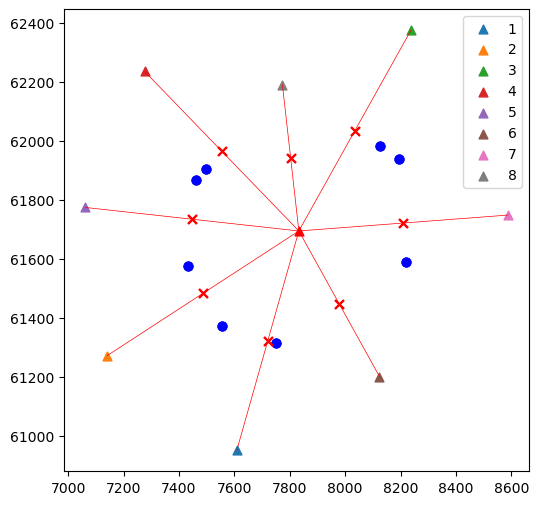

In [2]:
fig, ax = plt.subplots(figsize = (6,6))
plt.scatter(pt[0], pt[1],s=40, marker='^', c='red')
plt.scatter(cc[:,0], cc[:,1],s=40, marker='o', c='blue')
plt.scatter(mpt[:,0], mpt[:,1],s=40, marker='x', c='red')

for k in range(len(ngb)):
    ax.scatter(ngb[k,0], ngb[k,1], s=40, marker='^', label=k+1)

ax.legend()

for k in range(len(ngb)):
    plt.plot([pt[0],ngb[k,0]],[pt[1],ngb[k,1]],'r',lw=0.5)


# ax.set_xlabel('Time (ky)')
# ax.set_ylabel('Sea-level (m)')
plt.show()

In [3]:
coords = np.zeros((len(ngb)+1,2))
coords[0,:] = pt
coords[1:,:] = ngb

face = np.zeros((8,3),dtype=int)
face[0,:] = np.asarray([0,5,4])
face[1,:] = np.asarray([0,4,8])
face[2,:] = np.asarray([0,8,3])
face[3,:] = np.asarray([0,3,7])
face[4,:] = np.asarray([0,7,6])
face[5,:] = np.asarray([0,6,1])
face[6,:] = np.asarray([0,1,2])
face[7,:] = np.asarray([0,2,5])

In [4]:
import meshplex

# tmesh = meshplex.MeshTri(coords, face)
# larea = np.abs(tmesh.control_volumes)
# cc2 = tmesh.cell_circumcenters
# edges_nodes = tmesh.edges["points"]
# cells_nodes = tmesh.cells("points")
# cells_edges = tmesh.cells("edges")

In [6]:
cc2

array([[ 7460.71225092, 61868.05352231],
       [ 7497.27733112, 61905.76045556],
       [ 8124.64980731, 61981.04127189],
       [ 8194.92457995, 61939.1772549 ],
       [ 8219.764688  , 61590.58559365],
       [ 7751.40191994, 61313.90874428],
       [ 7553.34919254, 61373.66866088],
       [ 7430.49731889, 61575.17082115]])

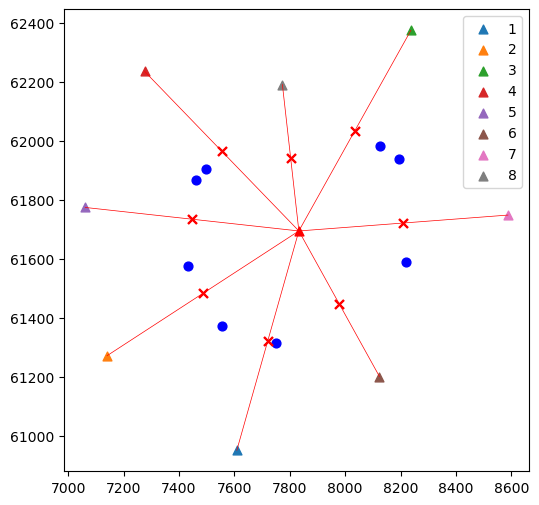

In [7]:
fig, ax = plt.subplots(figsize = (6,6))
plt.scatter(pt[0], pt[1],s=40, marker='^', c='red')
plt.scatter(cc2[:,0], cc2[:,1],s=40, marker='o', c='blue')
plt.scatter(mpt[:,0], mpt[:,1],s=40, marker='x', c='red')

for k in range(len(ngb)):
    ax.scatter(ngb[k,0], ngb[k,1], s=40, marker='^', label=k+1)

ax.legend()

for k in range(len(ngb)):
    plt.plot([pt[0],ngb[k,0]],[pt[1],ngb[k,1]],'r',lw=0.5)


# ax.set_xlabel('Time (ky)')
# ax.set_ylabel('Sea-level (m)')
plt.show()

(20, 6.114563414643828e-06)

In [9]:
import optimesh

In [38]:
optimesh.optimize(tmesh, "CVT (full)", 1.e-12, 300)

(300, 4.411752465106439e-11)

In [39]:
tmesh.points, tmesh.cells

(array([[ 7776.74846783, 61646.13624547],
        [ 7608.65875715, 60951.81192796],
        [ 7140.14608221, 61272.2514993 ],
        [ 8237.62139942, 62374.13873609],
        [ 7275.83031387, 62234.59469256],
        [ 7061.07047229, 61774.13755505],
        [ 8124.02534225, 61201.4743187 ],
        [ 8588.11692913, 61748.35198128],
        [ 7773.26574904, 62190.36743024]]),
 <bound method _uZvYj.cells of <meshplex triangle mesh, 9 points, 8 cells>>)

In [40]:
larea = np.abs(tmesh.control_volumes)
cc2 = tmesh.cell_circumcenters
edges_nodes = tmesh.edges["points"]
cells_nodes = tmesh.cells("points")
cells_edges = tmesh.cells("edges")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


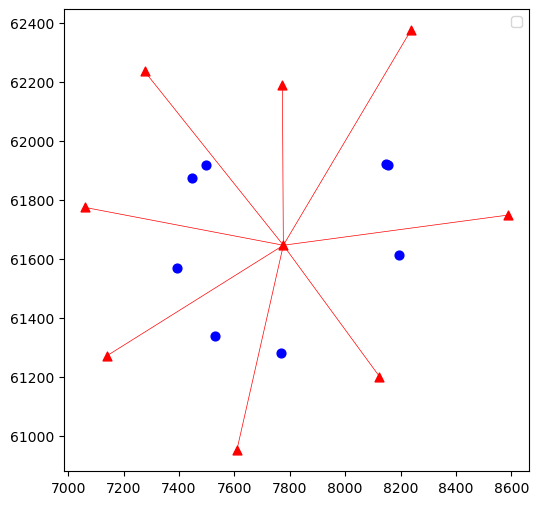

In [41]:
fig, ax = plt.subplots(figsize = (6,6))
plt.scatter(tmesh.points[:,0], tmesh.points[:,1],s=40, marker='^', c='red')
plt.scatter(cc2[:,0], cc2[:,1],s=40, marker='o', c='blue')
# plt.scatter(mpt[:,0], mpt[:,1],s=40, marker='x', c='red')

# for k in range(len(ngb)):
#     ax.scatter(ngb[k,0], ngb[k,1], s=40, marker='^', label=k+1)

ax.legend()

for k in range(len(ngb)):
    plt.plot([tmesh.points[0,0],tmesh.points[k+1,0]],
             [tmesh.points[0,1],tmesh.points[k+1,1]],'r',lw=0.5)


# ax.set_xlabel('Time (ky)')
# ax.set_ylabel('Sea-level (m)')
plt.show()